In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset


In [19]:
# Hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [20]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # New conv layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # Adjusted for the output size after adding conv4
        self.fc2 = nn.Linear(512, 4)  # Output layer for 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  # Added pooling after conv4
        x = x.view(-1, 256 * 14 * 14)  # Flatten the tensor, adjust based on new conv4
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
# Load the full dataset
data_dir = 'Multi-class Weather Dataset'  # Update with dataset path
full_dataset = datasets.ImageFolder(root=data_dir)

In [22]:
full_dataset

Dataset ImageFolder
    Number of datapoints: 1125
    Root location: Multi-class Weather Dataset

In [23]:
all_labels = np.array(full_dataset.targets)  # Extract class labels
num_samples = len(all_labels)
indices = np.arange(num_samples)

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, val_idx in splitter.split(indices, all_labels):
    train_indices, val_indices = train_idx, val_idx

# Create training and validation datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [24]:
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']

In [25]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [26]:
model = CustomCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
# Train the model
train_acc, val_acc = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
    train_acc.append(100 * correct.double() / len(train_dataset))

    # Validation Phase
    model.eval()
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_val += torch.sum(preds == labels.data)
    val_acc.append(100 * correct_val.double() / len(val_dataset))

    print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {train_acc[-1]:.2f}%, Validation Accuracy: {val_acc[-1]:.2f}%')


Epoch 1/10, Training Accuracy: 63.89%, Validation Accuracy: 71.56%
Epoch 2/10, Training Accuracy: 80.33%, Validation Accuracy: 76.44%
Epoch 3/10, Training Accuracy: 85.11%, Validation Accuracy: 83.11%
Epoch 4/10, Training Accuracy: 87.67%, Validation Accuracy: 83.56%
Epoch 5/10, Training Accuracy: 91.78%, Validation Accuracy: 90.67%
Epoch 6/10, Training Accuracy: 88.78%, Validation Accuracy: 89.33%
Epoch 7/10, Training Accuracy: 91.22%, Validation Accuracy: 90.67%
Epoch 8/10, Training Accuracy: 93.22%, Validation Accuracy: 88.89%
Epoch 9/10, Training Accuracy: 93.11%, Validation Accuracy: 89.78%
Epoch 10/10, Training Accuracy: 94.67%, Validation Accuracy: 92.44%


In [28]:
# Evaluate model
y_true, y_pred, y_probs = [], [], []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

[[53  1  5  1]
 [ 3 36  3  1]
 [ 0  2 49  0]
 [ 0  0  1 70]]


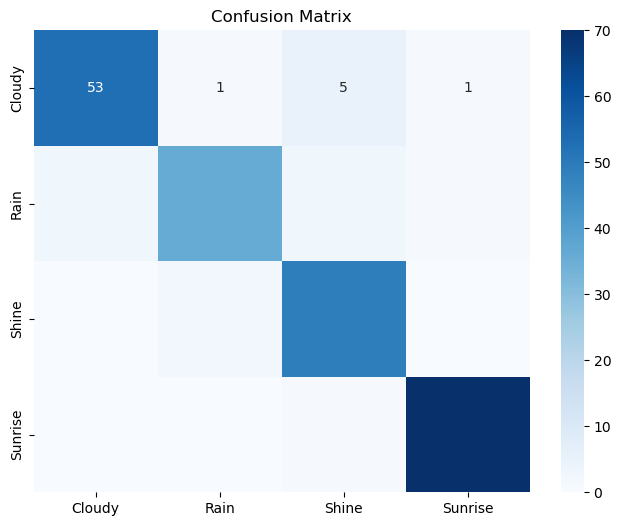

In [39]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title('Confusion Matrix')
plt.show()

In [30]:
print(classification_report(y_true, y_pred, target_names=full_dataset.classes))

              precision    recall  f1-score   support

      Cloudy       0.95      0.88      0.91        60
        Rain       0.92      0.84      0.88        43
       Shine       0.84      0.96      0.90        51
     Sunrise       0.97      0.99      0.98        71

    accuracy                           0.92       225
   macro avg       0.92      0.92      0.92       225
weighted avg       0.93      0.92      0.92       225



In [31]:
y_true_bin = np.eye(len(full_dataset.classes))[y_true]
y_probs = np.array(y_probs)

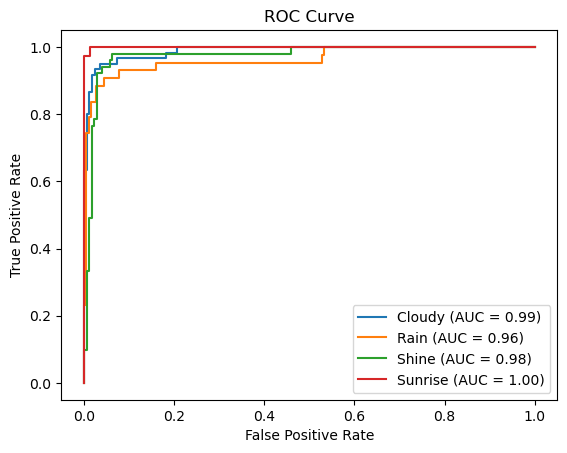

In [32]:
# Plot ROC Curves
plt.figure()
for i, class_name in enumerate(full_dataset.classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

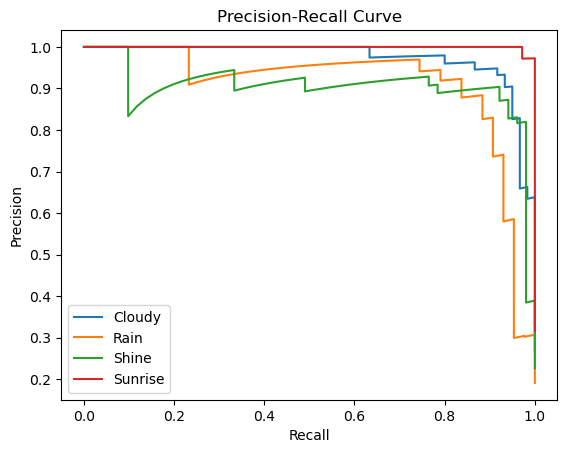

In [33]:
# Plot Precision-Recall Curves
plt.figure()
for i, class_name in enumerate(full_dataset.classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f'{class_name}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()
